This notebook demonstrates the basic features of the `nbgwas` package.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import nbgwas
from nbgwas import Nbgwas
import numpy as np
import pandas as pd

In [3]:
nbgwas.__version__

'0.4.0'

# Working with SNP and Genes Tables

`Nbgwas` requires two major components to work properly--**gene level summary** that contains p-values from genes, available from the `Genes` object, and a **network** that describes how the genes are connected, available from the `Network` objects. For genome wide association studies (GWAS), genomic information will be at the single nucleotide level. `Nbgwas` contains a class called `Snps` to handle this case.  

To gain access to the these internal objects, first instantiate the `Nbgwas` client by calling the constructor. If you have gene level information in the form of `pandas` Dataframe and a network in either `networkx` or `igraph` object, you can provide these to the constructor as well. See the manual or use the `help` function for more information. 

In [4]:
g = Nbgwas()

print(g.snps)
print(g.genes)
print(g.network)

Note that by instantiating the client, you will gain access to the all the methods asscoiated with the necessary objects even if there is no internal data. 

To load a SNP level summary, you can use the `from_file` method from the `snps` attribute. In order for `Nbgwas` to interpret the SNP locations, protein coding tables must also be provided along with the SNP table. The protein coding table describes where the locations on the genome so that `Nbgwas` can determine which of the coding gene, if any, a gene is closest to. All keyword arguments to pandas `read_csv` can be supplied as a keyword dictionary using `snp_kwargs` and `pc_kwargs`.

In [5]:
snp_level_summary_file = '../data/scz/snp_level_summary_stats_pmid_25056061.txt'
protein_coding_file = '../data/glist-hg18_proteinCoding.txt'

g.snps.from_files(
    snp_level_summary_file, 
    protein_coding_file, 
    snp_kwargs={'sep':'\s+'},
    pc_kwargs={'sep':'\s+', 'names':['Chrom', 'Start', 'End'], 'index_col':0}
)

In [6]:
g.snps.snp_table.head()

,snpid,hg18chr,bp,a1,a2,or,se,pval,info,ngt,CEUaf
0,rs3131972,1,742584,A,G,1.0257,0.0835,0.761033,0.1613,0,0.16055
1,rs3131969,1,744045,A,G,1.0221,0.0801,0.784919,0.2225,0,0.133028
2,rs3131967,1,744197,T,C,1.0227,0.0858,0.793520,0.2060,0,.
3,rs1048488,1,750775,T,C,0.9749,0.0835,0.761041,0.1613,0,0.836449
4,rs12562034,1,758311,A,G,1.0011,0.0756,0.987899,0.1856,3,0.0925926


In [7]:
g.snps.protein_coding_table.head()

,Chrom,Start,End
A1BG,19,63551643,63565932
A1CF,10,52271589,52315441
A2M,12,9111570,9159825
A2ML1,12,8911704,8930864
A3GALT2,1,33544953,33559286


To map SNPs to genes, you can use the `assign_snps_to_genes` in the `Snps` object.

In [8]:
g.genes = g.snps.assign_snps_to_genes(window_size=10000, to_Gene=True)

Alternatively, you can provide your own gene level summary that has mapped single nucleotide polymorphisms to genes. Note, doing this will overwrite the existing gene level summary. To load a gene level summary, use the `from_file` method associated with the `Genes` object which is pre-instantiated in Nbgwas `genes` attribute. This method allows the user to provide any keyword arguments associated with the `pandas` `read_csv` function. Additionally, the user needs to provide the column name associated with the p-values (`pval_col`) and gene name (`name_col`).

In [9]:
gene_level_summary_file = '../data/scz/gene_level_summary_stats_pmid_25056061.txt'

g.genes.from_file(
    gene_level_summary_file, 
    sep='\t', index_col=0, 
    pval_col='TopSNP P-Value', 
    name_col='Gene'
)

This table is loaded to the `table` attribute and can be accessed as follows. 

In [10]:
g.genes.table.head()

,Gene,Chr,Gene Start,Gene End,nSNPs,TopSNP,TopSNP Pos,TopSNP P-Value,SNP Distance
5905,HIST1H4K,6,27906930,27907284,8,rs34706883,27913234.0,5.071180e-10,6304.0
5867,HIST1H2AK,6,27913636,27914096,16,rs34706883,27913234.0,5.071180e-10,402.0
5883,HIST1H2BN,6,27914418,27914867,17,rs34706883,27913234.0,5.071180e-10,1184.0
5868,HIST1H2AL,6,27941085,27941555,10,rs13199772,27942064.0,7.053790e-10,979.0
5855,HIST1H1B,6,27942548,27943338,10,rs13199772,27942064.0,7.053790e-10,484.0


In order to convert the p-values to heat, you can use the `convert_to_heat` method associated with the `Genes` object. The result is appended to the table. 

In [11]:
g.genes.convert_to_heat(method='binarize', name='Binarized Heat')
g.genes.table.head()

,Gene,Chr,Gene Start,Gene End,nSNPs,TopSNP,TopSNP Pos,TopSNP P-Value,SNP Distance,Binarized Heat
5905,HIST1H4K,6,27906930,27907284,8,rs34706883,27913234.0,5.071180e-10,6304.0,1.0
2009,CCDC39,3,181908070,182070660,56,rs1879248,182033908.0,1.272380e-06,125838.0,1.0
12335,SLC17A3,6,25953306,25982450,37,rs9461219,25944906.0,4.003060e-07,8400.0,1.0
1416,BTN3A2,6,26476384,26484953,42,rs1978,26485552.0,4.755630e-07,9168.0,1.0
1414,BTN2A2,6,26491441,26503079,43,rs1978,26485552.0,4.755630e-07,5889.0,1.0


In [12]:
g.genes.convert_to_heat(method='neg_log', name='Negative Log')
g.genes.table.head()

,Gene,Chr,Gene Start,Gene End,nSNPs,TopSNP,TopSNP Pos,TopSNP P-Value,SNP Distance,Binarized Heat,Negative Log
5905,HIST1H4K,6,27906930,27907284,8,rs34706883,27913234.0,5.071180e-10,6304.0,1.0,21.402277
5867,HIST1H2AK,6,27913636,27914096,16,rs34706883,27913234.0,5.071180e-10,402.0,1.0,21.402277
5883,HIST1H2BN,6,27914418,27914867,17,rs34706883,27913234.0,5.071180e-10,1184.0,1.0,21.402277
5893,HIST1H3I,6,27947601,27948078,10,rs13199772,27942064.0,7.053790e-10,5537.0,1.0,21.072286
5906,HIST1H4L,6,27948904,27949268,10,rs13199772,27942064.0,7.053790e-10,6840.0,1.0,21.072286


# Adding Networks

Now that we have all the genes associated information, we can now load a network to enable a network analysis of the genes information. Like the methods associated with `Genes`, all network related methods is available in `network` attribute. There are many ways to load a network, including reading a serialized `networkx` object using `from_pickle`, pulling a network from NDex using `from_ndex`, or reading from a flat CX file using `from_cx`. If you already have a `networkx` or `igraph` graph, you can add it directly to the network using `client.network = myGraph`.

In [13]:
g.network.from_pickle('../data/networks/pcnet.pkl')

You can access node attributes using the `node_table`. Right now, it only contains the name for each gene. This table will contain the results of the network propagation later. 

In [14]:
g.network.node_table.head()

,name
0,UBE2Q1
1,RNF14
2,UBE2Q2
3,RNF10
4,RNF11


In order to move data from the `Genes` table to the `Network`'s `node_table`, you can use `map_to_node_table` method where you can specify the specific columns to map onto the network's node attributes. 

In [15]:
g.map_to_node_table(columns=['Binarized Heat', 'Negative Log'])
g.network.node_table.head()

,Binarized Heat,Negative Log,name
0,0.0,3.049072,UBE2Q1
1,0.0,3.184936,RNF14
2,0.0,1.235095,UBE2Q2
3,0.0,2.250201,RNF10
4,0.0,1.908012,RNF11


# Network Propagation

From there, the information is available for network propagation. 

In [16]:
g.diffuse(method='random_walk', alpha=0.8, node_attribute='Binarized Heat', result_name='Diffused (Binarized)')
g.network.node_table.head()

/cellar/users/samsonfong/Ongoing/nbgwas_package/nbgwas/propagation.py:57: UserWarning: Forcing F0 to be sparse
  warnings.warn("Forcing F0 to be sparse")


,Binarized Heat,Negative Log,name,Diffused (Binarized)
15215,1.0,14.399194,TCF4,0.823535
7301,1.0,14.820414,HIST1H2BC,0.814440
14802,1.0,14.533063,HIST1H4C,0.814388
4719,1.0,16.862172,ZKSCAN3,0.814367
14811,1.0,14.887917,HIST1H4J,0.813903


In [17]:
g.diffuse(method='random_walk', alpha=0.2, node_attribute='Negative Log', result_name='Diffused (Log)')
g.network.node_table.head()

/cellar/users/samsonfong/Ongoing/nbgwas_package/nbgwas/propagation.py:57: UserWarning: Forcing F0 to be sparse
  warnings.warn("Forcing F0 to be sparse")


,Binarized Heat,Negative Log,name,Diffused (Binarized),Diffused (Log)
8466,0.0,1.730928,UBC,0.030918,98.234079
341,0.0,11.557914,APP,0.004565,34.606344
1079,0.0,1.239945,HNF4A,0.009754,28.074621
4787,0.0,0.000000,TAF1,0.015459,27.823852
8206,0.0,3.251241,JUN,0.014097,26.689007


In [18]:
g.diffuse(method='heat_diffusion', node_attribute='Negative Log', result_name='Diffused (Heat, Log)')
g.network.node_table.head()

,Binarized Heat,Negative Log,name,Diffused (Binarized),Diffused (Log),"Diffused (Heat, Log)"
1323,0.0,10.960329,TMEM132E,1.167886e-07,2.204750,10.170592
19067,1.0,12.647988,MUSTN1,8.000999e-01,2.560178,10.066017
16461,1.0,12.367606,LY6G6F,8.005165e-01,2.519624,9.776831
8473,1.0,15.157662,PATE1,8.004600e-01,3.101642,8.799450
10711,1.0,12.385317,AGBL3,8.018084e-01,2.796266,8.790366


In [19]:
g.diffuse(method='heat_diffusion', node_attribute='Binarized Heat', result_name='Diffused (Heat, Binarize)')
g.network.node_table.head()

,Binarized Heat,Negative Log,name,Diffused (Binarized),Diffused (Log),"Diffused (Heat, Log)","Diffused (Heat, Binarize)"
16461,1.0,12.367606,LY6G6F,0.800516,2.519624,9.776831,0.744055
19067,1.0,12.647988,MUSTN1,0.800100,2.560178,10.066017,0.742368
10711,1.0,12.385317,AGBL3,0.801808,2.796266,8.790366,0.616114
8473,1.0,15.157662,PATE1,0.800460,3.101642,8.799450,0.501521
5925,1.0,17.424836,ZSCAN23,0.800947,3.765637,3.712298,0.080481


To sync the information from the node table to node attributes, use the `refresh_node_attributes` method.

In [20]:
g.network.refresh_node_attributes()

# Viewing and Interacting with Networks

/cellar/users/samsonfong/Ongoing/nbgwas_package/nbgwas/network.py:386: UserWarning: The specified graph does not have the attribute Diffused (Binarize). Replacing values with 0.
  "The specified graph does not have the attribute %s. Replacing values with 0." % attributes
/cellar/users/samsonfong/bin/anaconda3/envs/nbgwas2/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/cellar/users/samsonfong/bin/anaconda3/envs/nbgwas2/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/cellar/users/samsonfong/bin/anaconda3/envs/nbgwas2/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: T

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2f0f60d400>)

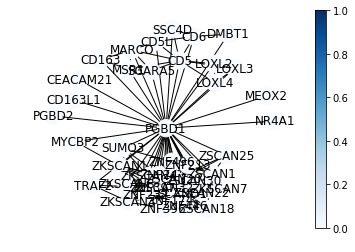

In [21]:
g.network.local_neighborhood(center_name='PGBD1', neighbors=1).view(attributes='Diffused (Binarize)', vmin=0, vmax=1)

# Evaluating Performance

In [22]:
with open('../../nbgwas_analysis/data/gold_standards/SZ_hugo_genes_only.txt') as f: 
    gold_standard = [i.strip() for i in f.readlines()]

In [23]:
g.genes.table.head()

,Gene,Chr,Gene Start,Gene End,nSNPs,TopSNP,TopSNP Pos,TopSNP P-Value,SNP Distance,Binarized Heat,Negative Log
5905,HIST1H4K,6,27906930,27907284,8,rs34706883,27913234.0,5.071180e-10,6304.0,1.0,21.402277
5867,HIST1H2AK,6,27913636,27914096,16,rs34706883,27913234.0,5.071180e-10,402.0,1.0,21.402277
5883,HIST1H2BN,6,27914418,27914867,17,rs34706883,27913234.0,5.071180e-10,1184.0,1.0,21.402277
5893,HIST1H3I,6,27947601,27948078,10,rs13199772,27942064.0,7.053790e-10,5537.0,1.0,21.072286
5906,HIST1H4L,6,27948904,27949268,10,rs13199772,27942064.0,7.053790e-10,6840.0,1.0,21.072286


In [24]:
g.map_to_gene_table(['Diffused (Binarized)'])

In [27]:
g.genes.table.head()

,Gene,Chr,Gene Start,Gene End,nSNPs,TopSNP,TopSNP Pos,TopSNP P-Value,SNP Distance,Binarized Heat,Negative Log,Binarized Heat,Negative Log,Diffused (Binarized),Diffused (Log),"Diffused (Heat, Log)","Diffused (Heat, Binarize)"
5905,HIST1H4K,6,27906930,27907284,8,rs34706883,27913234.0,5.071180e-10,6304.0,1.0,21.402277,0.0,0.0,0.0,0.0,0.0,0.0
5867,HIST1H2AK,6,27913636,27914096,16,rs34706883,27913234.0,5.071180e-10,402.0,1.0,21.402277,0.0,0.0,0.0,0.0,0.0,0.0
5883,HIST1H2BN,6,27914418,27914867,17,rs34706883,27913234.0,5.071180e-10,1184.0,1.0,21.402277,0.0,0.0,0.0,0.0,0.0,0.0
5893,HIST1H3I,6,27947601,27948078,10,rs13199772,27942064.0,7.053790e-10,5537.0,1.0,21.072286,0.0,0.0,0.0,0.0,0.0,0.0
5906,HIST1H4L,6,27948904,27949268,10,rs13199772,27942064.0,7.053790e-10,6840.0,1.0,21.072286,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
g.hypergeom(gold_standard, 'Diffused (Log)')

Hypergeom(pvalue=0.5147966063043954, n_intersect=5, common_items={'FGFBP1', 'EIF2B3', 'PIP5K1C', 'PTEN', 'NEFL'})